# Quick start tutorial for CytoVI
In this tutorial, we go through the steps of training CytoVI, a deep generative model that leverages antibody-based single-cell profiles to learn a biologically meaningful latent representation of each cell. CytoVI is designed for protein expression measurements (from flow cytometry, mass cytometry or CITE-seq data) and captures both technical and biological variation, enabling the generation of denoised marker intensities and interpretable low-dimensional embeddings.

In this tutorial, we go through the steps of training a CytoVI model using full spectrum cytometry data of peripheral blood mononuclear cells (PBMCs). We will analyze two repeated measurements of cryopreserved PBMCs from the same biological donor that were thawed and analyzed on two consecutive days (and thereby only differ in technical variation). We will demonstrate how CytoVI yields a joint cell state representation across these two measurements and effectively mitigates technical variation. We will then utilized this shared cell representation to annotate the immune subsets present in the PBMCs and quantify their abundance.

Plan for this tutorial:

1. Loading the data
2. Preprocessing the data and quality control
3. Training a CytoVI model
4. Visualizing and clustering the CytoVI latent space
4. Quantifying the abundance of immune cells present in the PBMCs

In [1]:
# Install from GitHub for now
!pip install --quiet scvi-colab
from scvi_colab import install

install()

/home/projects/amit/floriani/mambaforge/envs/cytovi_integration_env/lib/python3.11/site-packages/scvi_colab/_core.py:42: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import ContextualVersionConflict
/home/projects/amit/floriani/mambaforge/envs/cytovi_integration_env/lib/python3.11/site-packages/scvi_colab/_core.py:47: UserWarning: 
                Not currently in Google Colab environment.

                Please run with `run_outside_colab=True` to override.

                Returning with no further action.
                
  warn(


In [11]:
import os
import random
import tempfile

import numpy as np  # type: ignore
import matplotlib.pyplot as plt # type: ignore
import scanpy as sc  # type: ignore
import scvi  # type: ignore
import torch  # type: ignore
from rich import print  # type: ignore

sc.set_figure_params(figsize=(4, 4))
save_dir = tempfile.TemporaryDirectory()

scvi.settings.seed = 0
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
print("Last run with scvi-tools version:", scvi.__version__)

Seed set to 0


Last run with scvi-tools version: 1.3.2

# Loading the data

For this tutorial we will use full spectrum cytometry data of a single antibody-panel targeting 35 protein parameters and additional morphological features for FSC and SSC from the SARS-CoV-2 vaccine study from Nuñez, Schmid & Power et al. 2023 (Nature Immunology, https://doi.org/10.1038/s41590-023-01499-w). We will download a subset of the data comprising one donor that was measured in two different batches and thus served as a internal batch normalization control of the original study. Importantly, these data have already been corrected for fluorescent spillover and live single cells were exported.

We will download the fcs files and store the cytometry data as an AnnData object, similarly as common practice in scRNAseq and spatial transcriptomics analyses. If you are unfamilliar with AnnData, you can get a quick start here: https://anndata.readthedocs.io/en/latest/tutorials/notebooks/getting-started.html.

When reading the fcs files we will omit variables that are not informative for downstream processing `remove_markers=['Time', 'LD', '-']`. By default we store the raw protein expression in `adata.X` and `adata.layers['raw']`.

In [2]:
# replace by figshare data download
data_dir = '/home/projects/amit/floriani/Lab/PROJECTS/FlowVI/data/raw/Spectral flow/Nunez/For Chiquito/Raw_100000'
adata_batch1 = scvi.external.cytovi.read_fcs(f"{data_dir}/export_Tube_086_DownsampleDP.Pop_2.fcs", remove_markers=['Time', 'LD', '-'])
adata_batch2 = scvi.external.cytovi.read_fcs(f"{data_dir}/export_Tube_327_DownsampleDP.Pop_2.fcs", remove_markers=['Time', 'LD', '-'])
adata_batch1

/home/projects/amit/floriani/github_repos/scvi-tools-cytovi/src/scvi/external/cytovi/_read_write.py:95: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["filename"] = fcs_file
/home/projects/amit/floriani/github_repos/scvi-tools-cytovi/src/scvi/external/cytovi/_read_write.py:95: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["filename"] = fcs_file


AnnData object with n_obs × n_vars = 100000 × 41
    obs: 'filename', 'sample_id'
    layers: 'raw'

# Preprocessing the data and quality control

Before training CytoVI, we need to transform and normalize the cytometry data to make it more suitable for modeling.

Full spectrum cytometry produces fluorescence intensities that span several orders of magnitude. Because antibody-based single-cell measurements are relative by nature, preprocessing of the data is commonly performed before visualization or modeling. Cytometry data are typically transformed using functions like the hyperbolic arcsin, logicle, or biexponential to compress dynamic range and stabilize variance. This is usually followed by feature-wise scaling to ensure marker expression values are on comparable scales across all channels (more information can be found at Liechti et al. 2021, Nature Immunology, https://doi.org/10.1038/s41590-021-01006-z).

While CytoVI is capable of handling cytometry data preprocessed with any of these transformations, we here follow a simple two-step preprocessing strategy commonly used for cytometry:
1. This transformation is widely used in flow cytometry to stabilize variance and improve comparability across markers. It behaves linearly at low intensities and logarithmically at high intensities.
2.	Feature-wise min-max scaling
After transformation, we rescale each marker (feature) individually to the [0, 1] range to account for differences in brightness across different fluorophores or antibody affinities.


The choice of the arcsinh cofactor can influence the data. However, we have observed that CytoVI is relatively robust to the choice of the arcsinh cofactor and recommend a `global_scaling_factor` for all markers as following:
- 2000 for full spectrum cytometry (recommended here)
- 100 for conventional PMT-based flow cytometry
- 5 for mass cytometry (CyTOF and CITE-seq)

Users can specify feature-specific arcsinh cofactors by providing a `scaling_dict` to `scvi.external.cytovi.arcsinh()`. By default `scvi.external.cytovi.arcsinh()` will take the `adata.layers['raw']` as input and write the arcsinh transformed expression into `adata.layers['transformed']`, while `scvi.external.cytovi.scale` will save the scaled expression in `adata.layers['scaled']`.

In [3]:
scvi.external.cytovi.arcsinh(adata_batch1, global_scaling_factor=2000)
scvi.external.cytovi.scale(adata_batch1)

scvi.external.cytovi.arcsinh(adata_batch2, global_scaling_factor=2000)
scvi.external.cytovi.scale(adata_batch2)

/tmp/ipykernel_3623443/278245467.py:1: UserWarning: Detected scatter features, which are omitted for transformation. 
Scatter features: FSC-A, FSC-H, SSC-A, SSC-B-A, SSC-B-H, SSC-H
  scvi.external.cytovi.arcsinh(adata_batch1, global_scaling_factor=2000)
/tmp/ipykernel_3623443/278245467.py:4: UserWarning: Detected scatter features, which are omitted for transformation. 
Scatter features: FSC-A, FSC-H, SSC-A, SSC-B-A, SSC-B-H, SSC-H
  scvi.external.cytovi.arcsinh(adata_batch2, global_scaling_factor=2000)


After processing each batch separately, we will combine the two batches using `scvi.external.cytovi.merge_batches()`. This will automatically register a `batch_key` in `adata.obs`. In case of differences in antibody panels between the batches, this function will automatically register a `nan_layer` that will handle the modeling of missing markers under the hood.

In [4]:
adata = scvi.external.cytovi.merge_batches([adata_batch1, adata_batch2])
adata

/home/projects/amit/floriani/mambaforge/envs/cytovi_integration_env/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 200000 × 41
    obs: 'filename', 'sample_id', 'batch'
    layers: 'raw', 'transformed', 'scaled'

For the ease of handling the data, we will subsample the combined data to 10 000 cells per batch.

In [5]:
adata = scvi.external.cytovi.subsample(adata, n_obs = 20000, groupby = 'batch')
adata

/home/projects/amit/floriani/github_repos/scvi-tools-cytovi/src/scvi/external/cytovi/_preprocessing.py:356: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  index = adata.obs.groupby(groupby, as_index=False).apply(


AnnData object with n_obs × n_vars = 20000 × 41
    obs: 'filename', 'sample_id', 'batch'
    layers: 'raw', 'transformed', 'scaled'

We can then inspect the scaled protein expression for all the markers in both batches using histograms or biaxial plots.

/home/projects/amit/floriani/github_repos/scvi-tools-cytovi/src/scvi/external/cytovi/_preprocessing.py:356: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  index = adata.obs.groupby(groupby, as_index=False).apply(


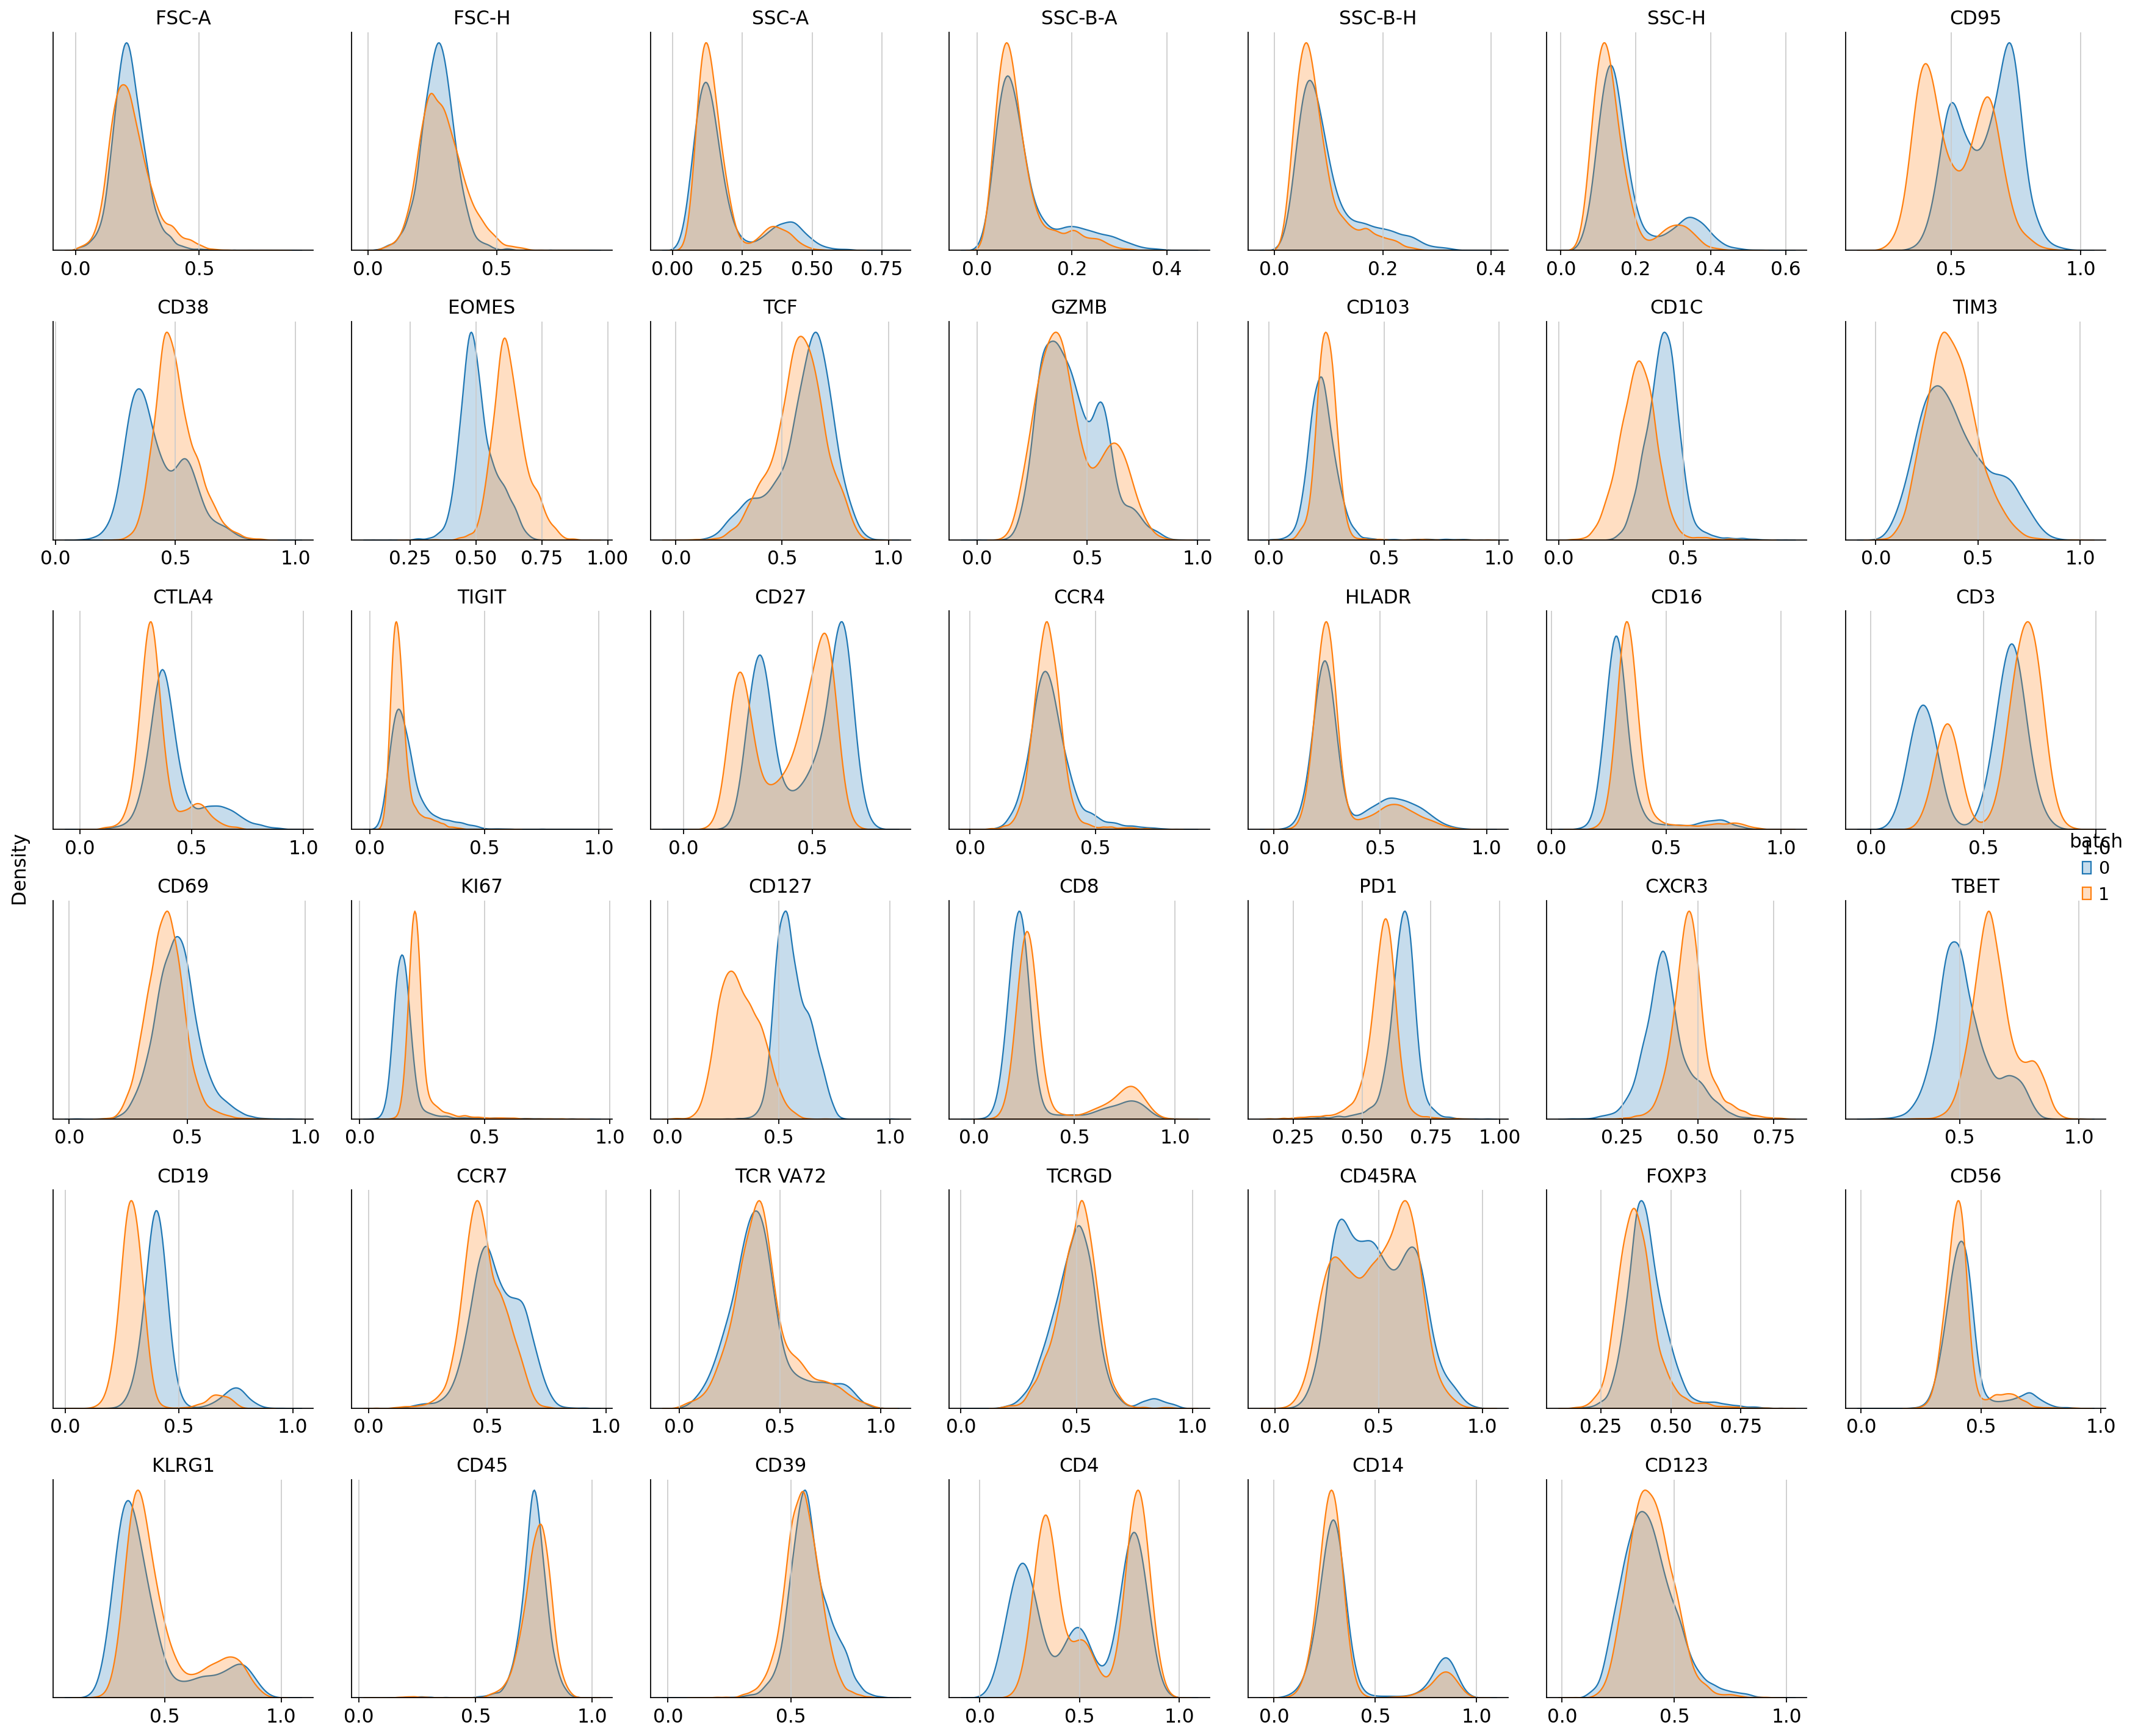

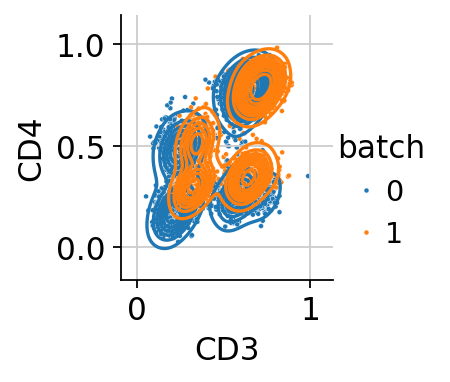

In [6]:
scvi.external.cytovi.histogram(adata, marker = 'all', groupby='batch', layer_key='scaled')
scvi.external.cytovi.biaxial(adata, marker_x = 'CD3', marker_y = 'CD4', color='batch', layer_key='scaled')

Inspection of these diagnostic plots indicates already the presence of technical variation between both batches. We will assess how this affects downstream analysis by generating an embedding of our data by computing a UMAP from the data without controlling for technical variation. Throughout this tutorial we will use the GPU-accellerated scanpy implementations to compute a nearest neighbor graph, UMAP and leiden clustering, which will lead to performance improvements when working with large datasets.

/home/projects/amit/floriani/mambaforge/envs/cytovi_integration_env/lib/python3.11/site-packages/legacy_api_wrap/__init__.py:82: FutureWarning: `method='rapids'` is deprecated. Use `rapids_singlecell.tl.louvain` instead.
  return fn(*args_all, **kw)


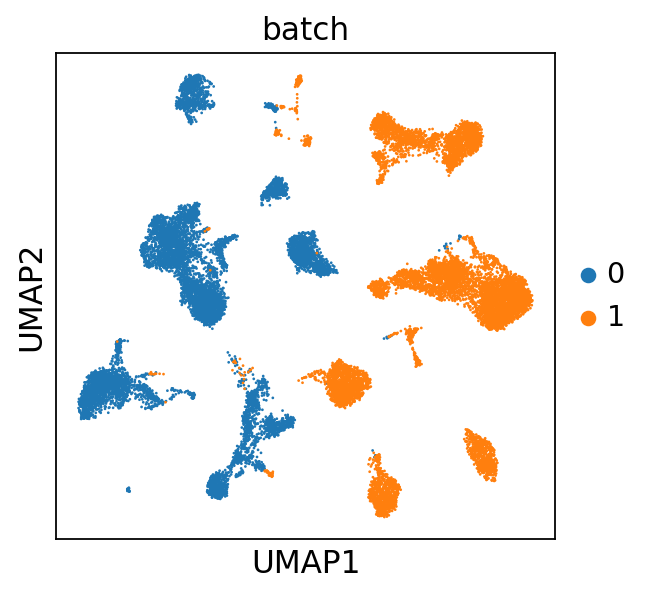

In [7]:
adata.X = adata.layers['scaled']
sc.pp.neighbors(adata, use_rep='X', transformer='pynndescent')
sc.tl.umap(adata, method = 'rapids')
sc.pl.umap(adata, color = 'batch')

# Training a CytoVI model

We observe that the technical variability between the two different batches virtually obsecurs a joint downstream analysis. Therefore, we will next train a CytoVI model that explicitly controls for the technical variation between batches. For this we will register the `scaled` layer as the input expression to the model and the `batch_key`. 

Optionally, the user can specify a `label_key` during AnnData setup, that can be used to weakly inform the model about a priori known cell type labels or we can specify a `sample_key`, indicating which cell came e.g. from which donor. Here we will showcase the simplest case of only specifying a `batch_key`.

In [8]:
scvi.external.cytovi.CYTOVI.setup_anndata(adata, layer='scaled', batch_key='batch')
model = scvi.external.CYTOVI(adata)
model.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A10') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 30 records. Best score: -66.819. Signaling Trainer to stop.


We can print the model to get some important summary statistics about the CytoVI model.

In [9]:
model

CytoVI Model with the following params: 
n_hidden: 128, n_latent: 20, n_layers: 1, dropout_rate: 0.1, 
protein_likelihood: normal, latent_distribution: normal, 
MoG prior: True, n_labels 1, n_proteins: 41, 
Impute missing markers: False
Training status: Trained

We can then assess the training dynamics of the model to see whether it has converged.

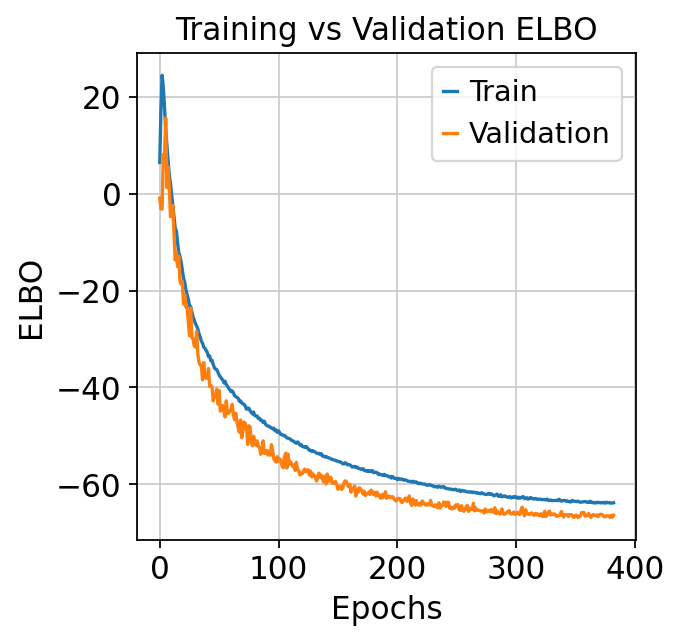

In [15]:
plt.plot(model.history['elbo_train'], label='Train')
plt.plot(model.history['elbo_validation'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('ELBO')
plt.legend()
plt.title('Training vs Validation ELBO')
plt.show()

# Visualizing and clustering the CytoVI latent space

Next we visualize the learnt latent representation of each cell that controls for the technical variability between batches. For this we access the latent space via `get_latent_representation` and compute an UMAP of the latent space.

/home/projects/amit/floriani/mambaforge/envs/cytovi_integration_env/lib/python3.11/site-packages/legacy_api_wrap/__init__.py:82: FutureWarning: `method='rapids'` is deprecated. Use `rapids_singlecell.tl.louvain` instead.
  return fn(*args_all, **kw)


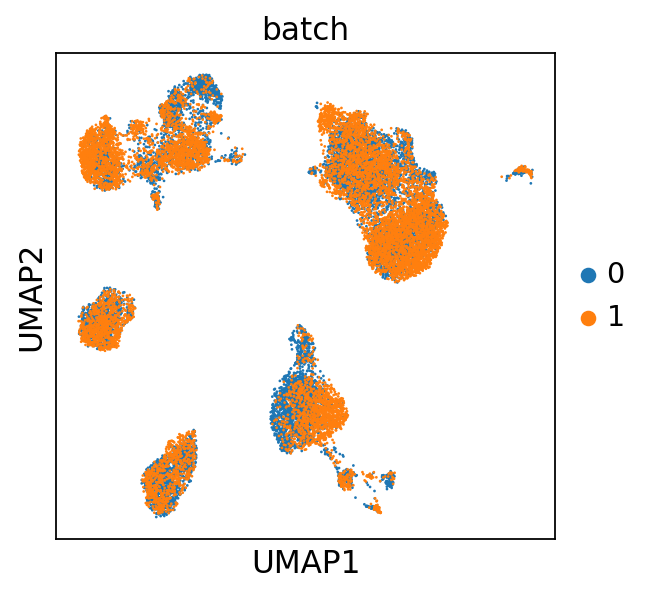

In [16]:
adata.obsm['X_CytoVI'] = model.get_latent_representation()
sc.pp.neighbors(adata, use_rep='X_CytoVI', transformer='pynndescent')
sc.tl.umap(adata, method = 'rapids')
sc.pl.umap(adata, color = 'batch')

We observe that this latent representation of the cells virtually removed the technical variation between the two batches. Next, we will compute the denoised (and batch corrected) protein expression and visualize it on top of the CytoVI latent space.

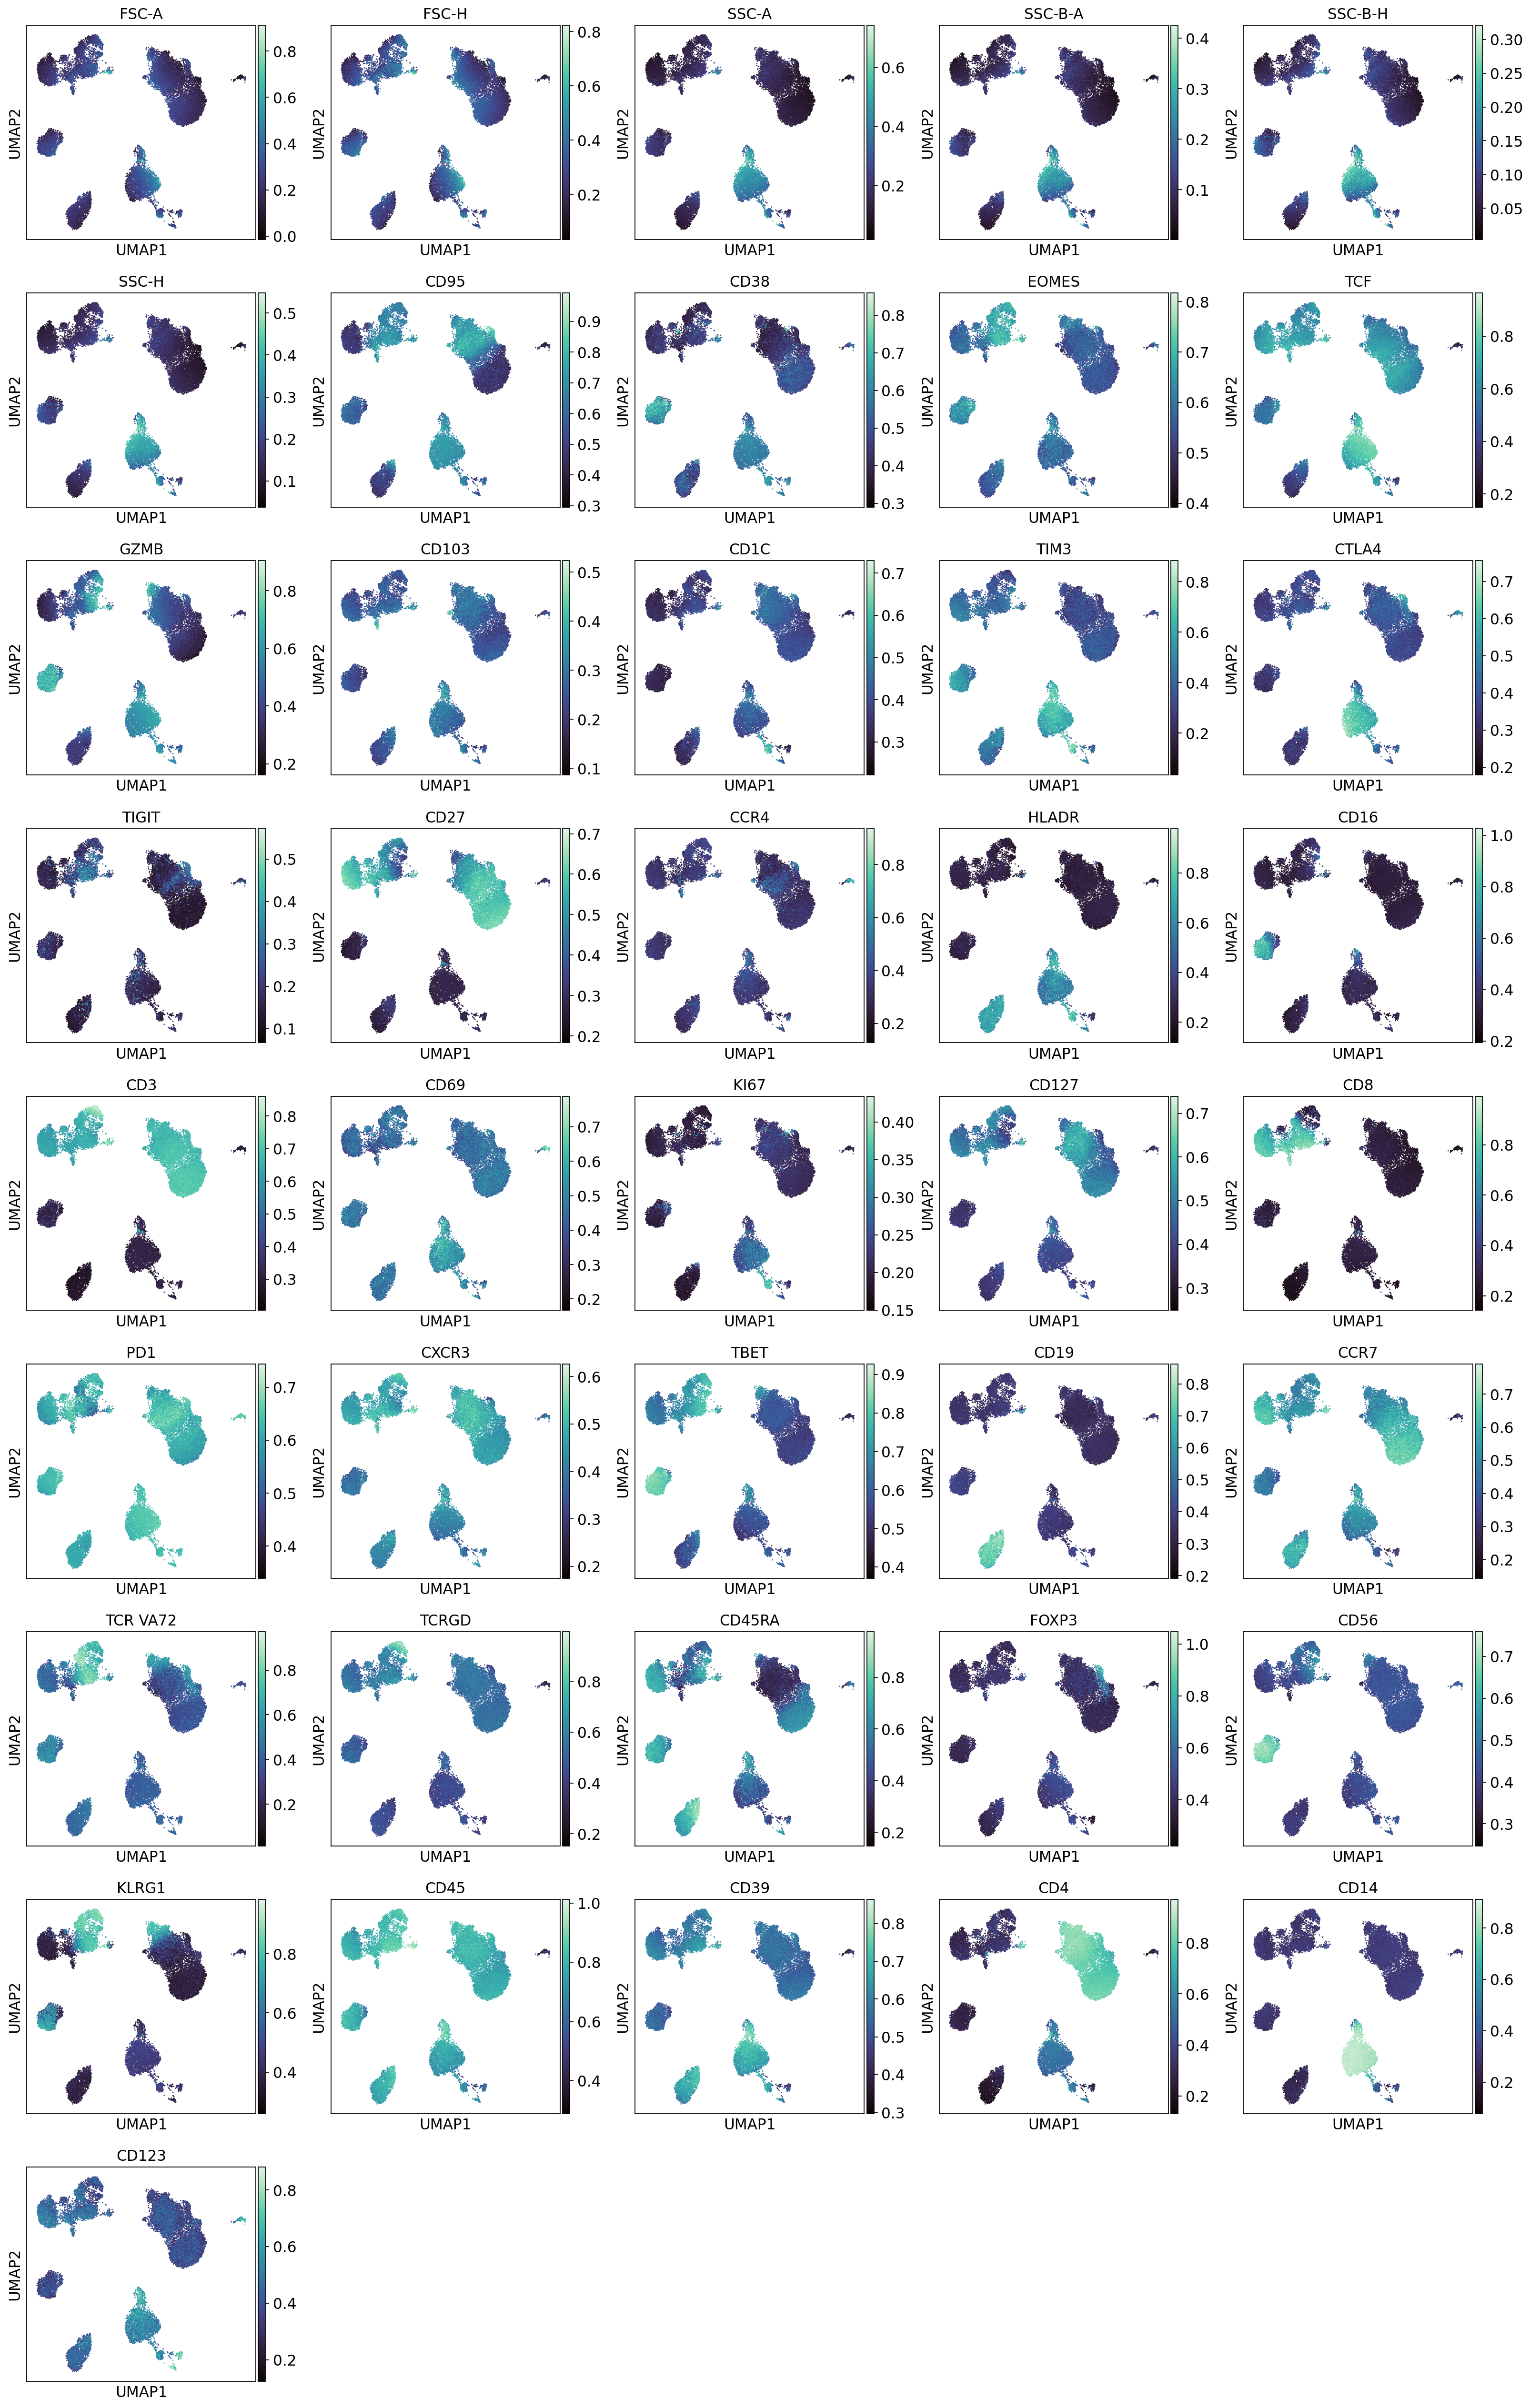

In [18]:
adata.layers['imputed'] = model.get_normalized_expression()

sc.pl.umap(adata, color = adata.var_names, layer = 'imputed', ncols = 5, cmap= 'mako')

/home/projects/amit/floriani/github_repos/scvi-tools-cytovi/src/scvi/external/cytovi/_preprocessing.py:356: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  index = adata.obs.groupby(groupby, as_index=False).apply(


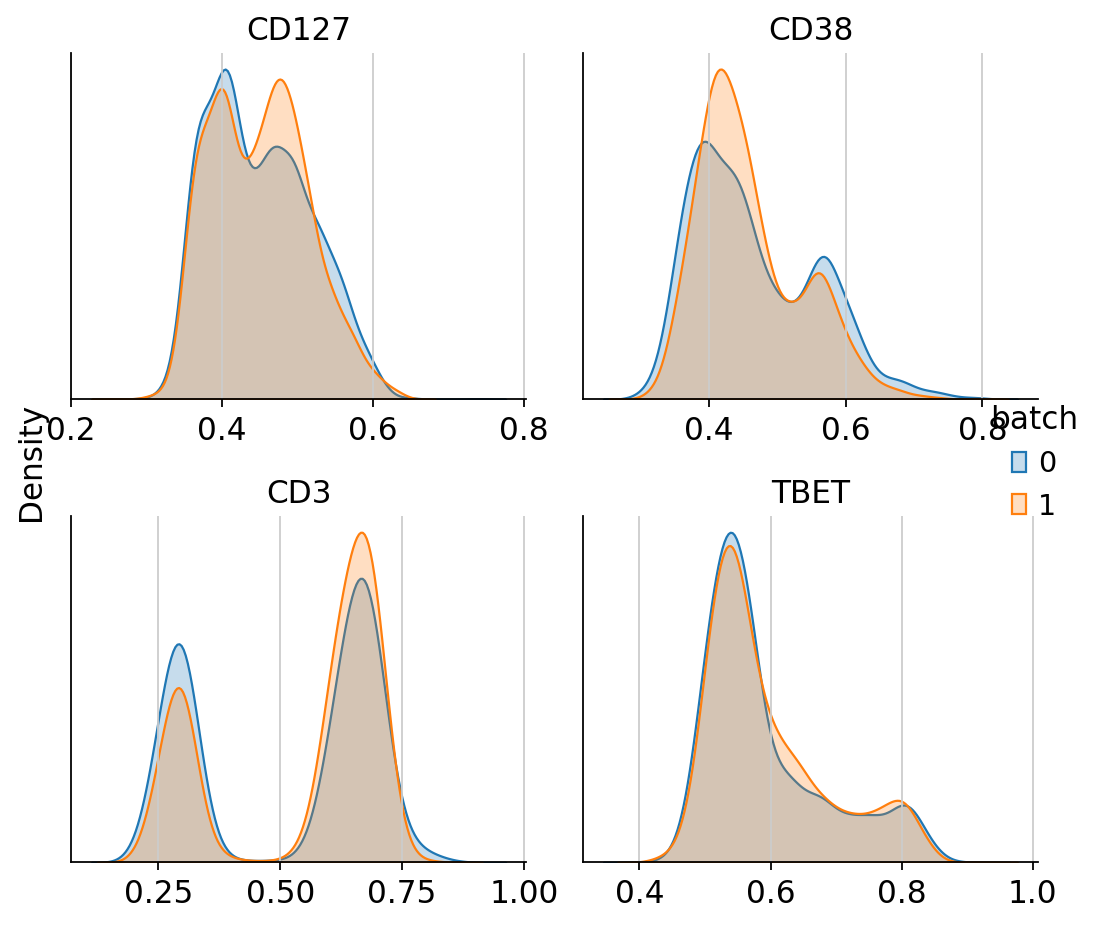

In [22]:
scvi.external.cytovi.histogram(adata, marker = ['CD127', 'CD38', 'CD3', 'TBET'], layer_key = 'imputed', groupby='batch')